In [1]:
from mesa import Model
from mesa.space import ContinuousSpace
from mesa.time import RandomActivation
from mesa.agent import Agent
import numpy as np
from mesa.datacollection import DataCollector
import math
import random

class TrafficModel(Model):
    def __init__(self,**params):
        self.init_mesa()
        self.patch_size=(50,50)
        self.setup_globals(params)
        self.power=params["power"]

        self.setup_patches()

        self.setup_cars(params["num_cars"])

        self.datacollector = DataCollector(
            model_reporters={
                "StoppedCars":self.get_stopped_cars,
                "AverageSpeed":self.get_average_speed,
                "AverageWaitTime":self.get_average_wait_time,
            }, agent_reporters={}
        )
    def get_stopped_cars(self):
        num=0
        for car in self.cars:
            if car.speed==0: 
                num+=1
                car.wait_time+=1
            else:
                car.wait_time=0
        return num
    def get_average_speed(self):
        speeds=0
        for car in self.cars:
            speeds+=car.speed
        return speeds/len(self.cars)
    def get_average_wait_time(self):
        waits=0
        for car in self.cars:
            waits+=car.wait_time
        return waits/len(self.cars)

    # def get_first_car_speed(self):
    #     return self.cars[0].speed
    # def get_min_speed(self):
    #     speeds=[]
    #     for car in self.cars:
    #         speeds.append(car.speed)
    #     return min(speeds)
    # def get_max_speed(self):
    #     speeds=[]
    #     for car in self.cars:
    #         speeds.append(car.speed)
    #     return max(speeds)

    def init_mesa(self):
        self.width, self.height=7000,7000
        self.space=ContinuousSpace(self.width,self.height,True)
        self.schedule=RandomActivation(self)
        self.running=True
        self.current_id=0
    
    def setup_globals(self,params):
        self.intersections=[]
        self.roads=[]

        self.phase=0
        self.num_cars_stopped=0
        self.grid_x_inc=self.patch_size[0]/params["grid_size_x"]
        self.grid_y_inc=self.patch_size[1]/params["grid_size_y"]

        self.acceleration=0.099
        self.tics_per_cycle=params["ticks_per_cycle"]
    
    def setup_cars(self,number_of_cars):
        self.cars=[]
        for _ in range(number_of_cars):
            car=Car(self.next_id(),self)
            self.schedule.add(car)
            self.space.place_agent(car,(car.x,car.y))
            self.cars.append(car)
            car.update_pos()

    def step(self):
        self.set_signals()
        self.schedule.step()
        self.datacollector.collect(self)
        self.next_phase()
    
    def set_signals(self):
        if not self.phase==0:return
        for road in self.intersections:
            road.green_light_up =not road.green_light_up
            road.set_signal_colors(self)

    def next_phase(self):
        self.phase+=1
        if self.phase%self.tics_per_cycle==0:
            self.phase=0
    
    
    def setup_patches(self):
        self.patches=[]
        self.patch_grid=[]
        x,y=self.patch_size[0],self.patch_size[1]
        self.patch_dimension=(self.width/self.patch_size[0],self.height/self.patch_size[1])
        for x in range(0,self.patch_size[0]):
            self.patch_grid.append([])
            for y in range(0,self.patch_size[1]):
                patch=Patch(x,y)
                self.patches.append(patch)
                self.patch_grid[x].append(patch)

                if (math.floor((x+self.patch_size[0]-math.floor(self.grid_x_inc-1))%self.grid_x_inc)==0)\
                    or (math.floor((y+1+self.patch_size[1])% self.grid_y_inc)==0):
                    self.roads.append(patch)
                    patch.color="white"
                    if (math.floor((x+self.patch_size[0]-math.floor(self.grid_x_inc-1))%self.grid_x_inc)==0)\
                    and (math.floor((y+1+self.patch_size[1])% self.grid_y_inc)==0):
                       self.intersections.append(patch) 
                       patch.setup_intersection(self)

        
class Patch:
    def __init__(self,x,y):
        self.x=x
        self.y=y
        self.agents=[]

        self.intersection=False
        self.green_light_up=False
        self.my_row=-1
        self.my_column=-1
        self.my_phase=-1
        self.color="grey"

    def setup_intersection(self,model):    
        self.intersection=True
        self.green_light_up=True
        self.my_phase=0
        # patch.auto=True
        self.my_row=math.floor((self.y+model.patch_size[1])/model.grid_y_inc)
        self.my_column=math.floor((self.x+model.patch_size[0])/model.grid_x_inc)
        self.set_signal_colors(model)

        # set intersection? false
        # set auto? false
        # set green-light-up? true
        # set my-row -1
        # set my-column -1
        # set my-phase -1
        # set pcolor brown + 3

    def set_signal_colors(self,model):
        patch_left=model.patch_grid[self.x-1][self.y]
        patch_top=model.patch_grid[self.x][self.y-1]
        if not model.power: 
            patch_left.color="white"
            patch_top.color="white"
            return
        if self.green_light_up:
            patch_left.color="red"
            patch_top.color="green"
        else:
            patch_left.color="green"
            patch_top.color="red"


speed_min=0
speed_limit=1

class Car(Agent):

    def __init__(self,unique_id,model,**kwargs):
        super().__init__(unique_id,model)
        self.model=model
        self.up_car=False
        self.x=0
        self.y=0
        self.put_on_empty_road()

        self.heading=(90 if self.up_car else 0)*np.pi/180
        self.speed=np.random.uniform(0.1,1.0)
        self.wait_time=0
        

    def put_on_empty_road(self):
        shuffled_roads = random.sample(self.model.roads, k=len(self.model.roads))
        for road in shuffled_roads:
            if not road.agents:
                self.patch_coords=(road.x,road.y)
                self.x=road.x*self.model.patch_dimension[0]+self.model.patch_dimension[0]/2
                self.y=road.y*self.model.patch_dimension[1]+self.model.patch_dimension[1]/2
                self.model.patch_grid[road.x][road.y].agents.append(self)

                if road.intersection:
                    self.up_car=random.random() >= 0.5
                else:
                    self.up_car=math.floor((road.x+self.model.patch_size[0]-math.floor(self.model.grid_x_inc-1))%self.model.grid_x_inc)==0
                break

    
    def update_pos(self):
        patch_coords_org=self.patch_coords
        self.patch_coords=(int(self.model.patch_size[0]/self.model.width*self.x),int(self.model.patch_size[1]/self.model.height*self.y))
        if not patch_coords_org==self.patch_coords:
            self.model.patch_grid[patch_coords_org[0]][patch_coords_org[1]].agents.remove(self)
            self.model.patch_grid[self.patch_coords[0]][self.patch_coords[1]].agents.append(self)
    
    def step(self):
        if self.model.patch_grid[self.patch_coords[0]][self.patch_coords[1]].color=="red":
            self.speed=0
            return

        if self.up_car:
            patch_ahead=self.model.patch_grid[self.patch_coords[0]][self.patch_coords[1]+1] if self.patch_coords[1]+1<self.model.patch_size[1] else self.model.patch_grid[self.patch_coords[0]][0]
        else:
            patch_ahead=self.model.patch_grid[self.patch_coords[0]+1][self.patch_coords[1]] if self.patch_coords[0]+1<self.model.patch_size[0] else self.model.patch_grid[0][self.patch_coords[1]]
        car_ahead=None if not patch_ahead.agents else patch_ahead.agents[-1]
        if car_ahead:
            if car_ahead.up_car==self.up_car:
                self.speed=0
            else:
                self.speed=car_ahead.speed
                self.slow_down_car(car_ahead)
        else:
            self.speed_up_car()
        self.speed=max(self.speed,speed_min)
        self.speed=min(self.speed,speed_limit)

        if self.up_car:
            self.y+=self.speed*30
            if self.y>=self.model.height:
                self.y-=self.model.height
        else:
            self.x+=self.speed*30
            if self.x>=self.model.width:
                self.x-=self.model.width
        self.model.space.move_agent(self,np.array([self.x,self.y]))
        self.update_pos()

    
    def slow_down_car(self,car_ahead):
        if self.speed<=0:
            self.speed=0
        else:
            self.speed=self.speed-self.model.acceleration

    def speed_up_car(self):
        if self.speed>speed_limit:
            self.speed=speed_limit
        else:
            self.speed=self.speed+self.model.acceleration

In [2]:
import mesa

In [3]:
params = {"grid_size_x":5,"grid_size_y":5,"ticks_per_cycle": range(30,71,10),"num_cars":100,"power":True,"speed_limit":1.0}
steps=1000

results = mesa.batch_run(
    TrafficModel,
    parameters=params,
    iterations=20,
    max_steps=steps,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
import pandas as pd
results_df = pd.DataFrame(results)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


In [4]:
results_filtered=results_df[(results_df.Step==steps-1)]
results_filtered=results_filtered.drop(["RunId","iteration","Step","grid_size_x","grid_size_y","num_cars","power","speed_limit","StoppedCars"],axis=1)
results_filtered=results_filtered.groupby(["ticks_per_cycle"]).mean()
results_filtered=results_filtered.round(2)
results_filtered

,AverageSpeed,AverageWaitTime
ticks_per_cycle,,
30,0.72,1.37
40,0.50,11.45
50,0.51,20.61
60,0.49,10.41
70,0.86,1.43


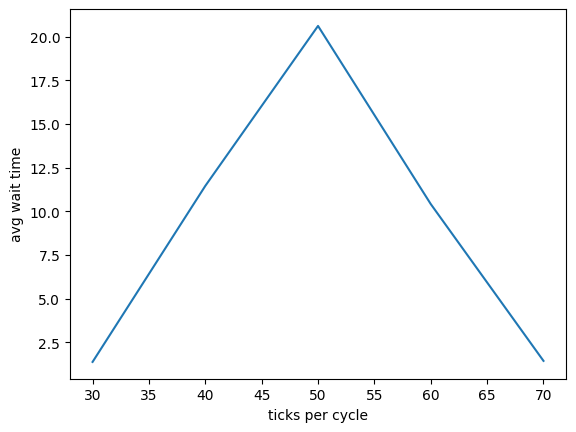

In [32]:
results2=results_df[(results_df.Step==steps-1)]

import matplotlib.pyplot as plt
plt.plot(results2.groupby('ticks_per_cycle')["ticks_per_cycle"].mean().values,results_filtered['AverageWaitTime'].values)
plt.xlabel('ticks per cycle')
plt.ylabel('avg wait time')
plt.show()


In [33]:
params = {"grid_size_x":5,"grid_size_y":5,"ticks_per_cycle": range(30,71,5),"num_cars":100,"power":True,"speed_limit":1.0}
steps=1000

results = mesa.batch_run(
    TrafficModel,
    parameters=params,
    iterations=20,
    max_steps=steps,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
import pandas as pd
results_df = pd.DataFrame(results)

100%|██████████| 180/180 [02:59<00:00,  1.00it/s]


In [34]:
results_filtered=results_df[(results_df.Step==steps-1)]
results_filtered=results_filtered.drop(["RunId","iteration","Step","grid_size_x","grid_size_y","num_cars","power","speed_limit","StoppedCars"],axis=1)
results_filtered=results_filtered.groupby(["ticks_per_cycle"]).mean()
results_filtered=results_filtered.round(2)
results_filtered

,AverageSpeed,AverageWaitTime
ticks_per_cycle,,
30,0.71,1.28
35,0.70,1.58
40,0.50,11.33
45,0.51,4.98
50,0.50,20.63
55,0.57,6.02
60,0.49,10.54
65,0.69,5.08
70,0.88,1.21


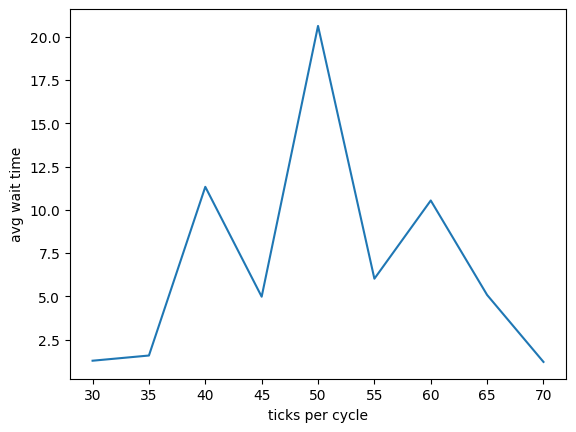

In [35]:
results2=results_df[(results_df.Step==steps-1)]

import matplotlib.pyplot as plt
plt.plot(results2.groupby('ticks_per_cycle')["ticks_per_cycle"].mean().values,results_filtered['AverageWaitTime'].values)
plt.xlabel('ticks per cycle')
plt.ylabel('avg wait time')
plt.show()
